In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [36]:
import numba

In [3]:
cd ..

/home/shibinbin/ibme/projects/Deepfold2


In [314]:
class Onehot(object):
    def __init__(self, alphabet='AUCG'):
        self.alphabet = np.asarray(list(alphabet), dtype='U1')

    def encode(self, s):
        x = np.asarray(list(s), dtype='U1')
        encoded = (x[:, np.newaxis] == self.alphabet[np.newaxis, :]).astype(np.int32)
        return encoded

    def decode(self, x):
        return ''.join(self.alphabet[np.argmax(x, axis=1)])
    
def fasta_to_onehot(filename, motif_only=False, return_names=False):
    '''Read a FASTA file and convert the sequences to onehot encoding
    Args:
        motif_only: parse motif position from sequence name and extract only motif instances
        parse_label: parser the sequence names to determine whether the sequence is random
    Returns:
        ndarray of shape (n_sequences, seq_length, alphabet_size)
    '''
    from Bio import SeqIO

    onehot = Onehot()
    dataset = []
    names = []
    for record in SeqIO.parse(filename, 'fasta'):
        if motif_only:
            start, end = [int(a) for a in record.id.split('/')[1].split('-')]
            start -= 1
            dataset.append(onehot.encode(str(record.seq)[start:end])[np.newaxis, :, :])
        else:
            dataset.append(onehot.encode(str(record.seq))[np.newaxis, :, :])
        if return_names:
            names.append(record.id)
    lengths = np.asarray([a.shape[1] for a in dataset])
    max_length = np.max(lengths)
    if not np.all(lengths == max_length):
        dataset_container = np.zeros((len(dataset), max_length, 4), dtype=np.int32)
        for i, a in enumerate(dataset):
            dataset_container[i, :a.shape[1], :] = a[0]
        dataset = dataset_container
    else:
        dataset = np.concatenate(dataset, axis=0)
    if return_names:
        return dataset, names
    else:
        return dataset
    
def read_transfac(filename, alphabet='AUCG'):
    record = {}
    with open(filename, 'r') as f:
        pfm = {}
        for line in f:
            tag = line[:2]
            if tag in ('XX', '//'):
                continue
            content = line[3:].strip()
            if tag.isdigit():
                pfm[int(tag)] = [float(a) for a in content.split()]
            elif tag == 'PO':
                record[tag] = content.split()
                record[tag] = [a.replace('T', 'U') for a in record[tag]]
            else:
                record[tag] = content
        alphabet_order = np.argmax(np.asarray(transfac['PO'])[:, np.newaxis] == np.asarray(list(alphabet), dtype='U1'), axis=1)
        #alphabet_order = np.arange(len(alphabet))
        pfm = [pfm[i] for i in range(1, len(pfm) + 1)]
        pfm = np.asarray(pfm)
        pfm = pfm[:, alphabet_order]
        record['LEN'] = pfm.shape[0]
        record['PFM'] = pfm
        record['NSEQ'] = sum(pfm[0])
        p = (pfm + 1)/np.sum(pfm + 1, axis=1, keepdims=True)
        record['PWM'] = p[:, alphabet_order]
        record['INFOBIT'] = -np.sum(p*np.log(p))
    return record

In [434]:
X, names = fasta_to_onehot('output/jaspar_sample/seq/128/MA0028.2.fa', return_names=True)
window_size = X.shape[1]
positions = np.asarray([a.split('/')[1].split('-')[0] for a in names], dtype=np.int32) - 1
transfac = read_transfac('data/JASPAR/vertebrates/MA0028.2.transfac')
motif_length = transfac['LEN']
np.asarray(list('AUCG'))[np.argmax(transfac['PWM'], axis=1)]

array(['A', 'C', 'C', 'G', 'G', 'A', 'A', 'G', 'U', 'G'], dtype='<U1')

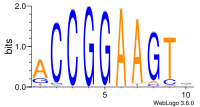

In [299]:
import subprocess
from io import BytesIO
from IPython.display import SVG
p = subprocess.Popen(['weblogo', '-D' 'transfac', '-F', 'svg', '-s' 'large',
                     '-f' 'data/JASPAR/vertebrates/MA0028.2.transfac'],
                     stdout=subprocess.PIPE)
weblogo, _ = p.communicate()
SVG(weblogo)

array(['A', 'U', 'U', 'C', 'C', 'A', 'A', 'C', 'G', 'C'], dtype='<U1')

In [289]:
transfac['PO']

['A', 'U', 'C', 'G']

In [263]:
np.argmax(np.asarray(transfac['PO'])[:, np.newaxis] == np.asarray(list('ATCG'), dtype='U1'), axis=0)

array([0, 3, 1, 2])

In [206]:
positions

array([ 54, 111, 118, ...,  28, 106,  17], dtype=int32)

In [357]:
def logL_motif(pwm, x):
    M, K = pwm.shape
    L = x.shape[0]
    logL = np.zeros(L - M + 1)
    for i in range(L - M + 1):
        for j in range(M):
            for k in range(K):
                logL[i] += x[i + j, k]*pwm[j, k]
    return logL

def logL_bg(bgprob, x, M):
    L, K = x.shape
    logLi = np.zeros(L)
    logL = np.zeros(L - M + 1)
    for i in range(L):
        for k in range(K):
            logLi[i] += x[i, k]*bgprob[k]
    for i in range(L - M + 1):
        for j in range(i, i + M):
            logL[i] += logLi[j]
    return logL

@numba.jit
def logL_motif_windows(pwm, X):
    N, M, K = X.shape
    logL = np.zeros(N)
    for i in range(N):
        for j in range(M):
            for k in range(K):
                logL[i] += X[i, j, k]*pwm[j, k]
    return logL

@numba.jit
def logL_bg_windows(bgprob, X):
    N, M, K = X.shape
    logL = np.zeros(N)
    for i in range(N):
        for j in range(M):
            for k in range(K):
                logL[i] += X[i, j, k]*bgprob[k]
    return logL

def sequences_to_windows(X, window_size):
    lengths = np.asarray([(x.shape[0] - window_size + 1) for x in X])
    ends = np.cumsum(lengths)
    starts = ends - lengths
    n_windows = np.sum(lengths)
    X_split = np.empty((n_windows, window_size, X[0].shape[1]), dtype=X[0].dtype)
    i = 0
    for x in X:
        for j in range(x.shape[0] - window_size + 1):
            X_split[i] = x[j:(j + window_size)]
            i += 1
    return X_split, starts, ends

class PwmModel(object):
    def __init__(self, window_size=3, n_channels=4):
        self.window_size = window_size
        self.n_channels = n_channels
        self.pwm = np.full((window_size, n_channels), 1.0/n_channels)
        self.bgprob = np.full(n_channels, 1.0/n_channels)
        self.mix = 0.5
    
    def init_params(self):
        self.pwm = np.random.uniform(size=(self.window_size, self.n_channels))
        self.pwm /= np.sum(self.pwm, axis=1, keepdims=True)
        #self.bgprob = np.random.uniform(size=self.n_channels)
        #self.bgprob /= np.sum(self.bgprob)
        self.mix = np.random.uniform(0, 1)
    
    def logL(self, x):
        motif = motif_likelihood(np.log(self.pwm), x)
        bg = logL_bg(np.log(self.bgprob), x, self.window_size)
    
    def fit_step(self, X_windows):
        N = X_windows.shape[0]
        # E-step
        L_motif = np.exp(logL_motif_windows(np.log(self.pwm), X_windows))
        L_bg = np.exp(logL_bg_windows(np.log(self.bgprob), X_windows))
        logL = np.sum(np.log(L_motif*self.mix + L_bg*(1.0 - self.mix)))
        weights_motif = (self.mix*L_motif)/(self.mix*L_motif + (1.0 - self.mix)*L_bg)
        weights_bg = 1.0 - weights_motif
        N_motif = np.sum(weights_motif)
        N_bg = np.sum(weights_bg)
        weights_motif /= N_motif
        weights_bg /= N_bg
        self.L_motif = L_motif
        self.L_bg = L_bg
        # M-step
        self.pwm = np.sum(X_windows*weights_motif[:, np.newaxis, np.newaxis], axis=0)
        self.bgprob = np.mean(np.sum(X_windows*weights_bg[:, np.newaxis, np.newaxis], axis=0), axis=0)
        self.mix = N_motif/N
        return logL

    def scan(self, X):
        X_windows, starts, ends = sequences_to_windows(X, self.window_size)
        L_motif = np.exp(logL_motif_windows(np.log(self.pwm), X_windows))
        L_bg = np.exp(logL_bg_windows(np.log(self.bgprob), X_windows))
        LR = L_motif/L_bg
        positions = np.zeros(X.shape[0])
        for i, start, end in zip(range(X.shape[0]), starts, ends):
            positions[i] = np.argmax(LR[start:end])
        return positions
            
    def fit(self, X, tol=1e-6, max_iter=30):
        '''Train the model
        Args:
            X: a list of onehot-encoded sequences (ndarray of shape (seq_length, n_channels))
        '''
        # break sequences into windows
        X_windows, starts, ends = sequences_to_windows(X, self.window_size)
        
        self.init_params()
        logL_old = 0
        i_iter = 0
        N = X_windows.shape[0]
        while True:
            logL = self.fit_step(X_windows)
            print('iter = {}, logL = {}'.format(i_iter, logL))
            i_iter += 1
            if i_iter >= max_iter:
                break
            if abs(logL - logL_old) < tol:
                break
            logL_old = logL
        
model = PwmModel(window_size=10, n_channels=4)
model.init_params()

In [476]:
X_windows, starts, ends = sequences_to_windows(X, window_size=10)
model.init_params()
# initialize the PWM with the motif
model.pwm = transfac['PWM'].copy()
# pertub the PWM by add pseudocounts
model.pwm += 0.2
model.pwm /= np.sum(model.pwm, axis=1, keepdims=True)
# perturb the PWM by disrupt one position
#model.pwm[np.random.randint(model.pwm.shape[0], size=8)] = 0.25
positions_pred = model.scan(X)
iou = iou_score(positions, positions_pred, motif_length)
print('IOU before optimization: %.6f'%iou.mean())
print('Distance before optimization: %.6f'%pwm_distance(model.pwm, transfac['PWM']))
for i in range(6):
    print(model.fit_step(X_windows))
positions_pred = model.scan(X)
iou = iou_score(positions, positions_pred, motif_length)
print('IOU after optimization: %.6f'%iou.mean())
print('Distance after optimization: %.6f'%pwm_distance(model.pwm, transfac['PWM']))
#model.fit(X, max_iter=5)

IOU before optimization: 0.978050
Distance before optimization: 0.224706
-8980044.948914368
-8266973.389725641
-8250868.458283302
-8247536.426560651
-8246336.000672985
-8245769.7751981225
IOU after optimization: 0.958557
Distance after optimization: 0.479623


In [ ]:
motif_likelihood

In [479]:
model.pwm

array([[0.27651525, 0.20978517, 0.2500302 , 0.26366938],
       [0.25841968, 0.20570823, 0.28246416, 0.25340793],
       [0.24783153, 0.20712364, 0.28382941, 0.26121542],
       [0.24284949, 0.20972851, 0.24835116, 0.29907084],
       [0.25371726, 0.21133603, 0.23544809, 0.29949862],
       [0.29045764, 0.20828311, 0.23971156, 0.2615477 ],
       [0.29210415, 0.20657788, 0.24415032, 0.25716766],
       [0.25696484, 0.21251852, 0.24596656, 0.28455008],
       [0.24261679, 0.23883618, 0.24711402, 0.27143302],
       [0.25877784, 0.22239291, 0.24613414, 0.27269511]])

In [463]:
def pwm_distance(a, b):
    assert a.shape == b.shape
    M, K = a.shape
    return np.sum(np.sqrt(np.sum((a - b)**2, axis=1)), axis=0)/(M*np.sqrt(2))
pwm_distance(model.pwm, transfac['PWM'])

0.28399065785845873

In [464]:
def iou_score(positions_true, positions_pred, motif_length):
    distance = np.abs(positions_true - positions_pred)
    return np.maximum(motif_length - distance, 0)/(motif_length + distance)
positions_pred = model.scan(X)
iou = iou_score(positions, positions_pred, motif_length)
iou.mean()

0.8984807665330885

In [369]:
iou.mean()

0.9917505252439327

In [475]:
np.sum(model.pwm, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

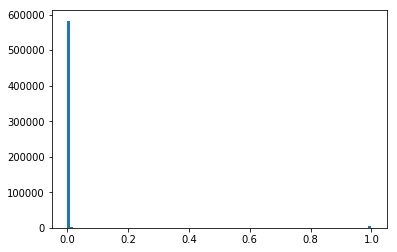

In [319]:
weights = model.L_motif/(model.L_motif + model.L_bg)
h = hist(weights, bins=100)

In [281]:
model.pwm

array([[0.54029894, 0.1423818 , 0.17594971, 0.14136955],
       [0.08519961, 0.06801746, 0.75172538, 0.09505755],
       [0.05824157, 0.05605452, 0.86131803, 0.02438588],
       [0.00109885, 0.00131767, 0.01399859, 0.98358489],
       [0.00425285, 0.00582297, 0.02015003, 0.96977415],
       [0.75636239, 0.20348443, 0.02725742, 0.01289576],
       [0.74045421, 0.20028605, 0.04825854, 0.0110012 ],
       [0.11957773, 0.07890822, 0.13149654, 0.67001751],
       [0.09398939, 0.49558846, 0.24879133, 0.16163082],
       [0.27952809, 0.14934578, 0.26071145, 0.31041468]])

In [280]:
model.L_motif

array([1.98273889e-17, 6.00208796e-12, 1.29797615e-10, ...,
       1.23005973e-20, 1.00030719e-17, 9.60473637e-18])

In [209]:
np.sum(weights > 0.95)

43559

In [348]:
positions[:20]

array([ 44, 101, 108, 115,  52,  68,  34,  83,   0,  86,  18,  48,  74,
         9,  96,  24,  67,  76,  37,  14], dtype=int32)

In [247]:
motif_length

4

In [246]:
motif_length*np.log(0.25)

-5.545177444479562

In [254]:
print(start, end)

236 354


Text(0,0.5,'Likelihood ratio')

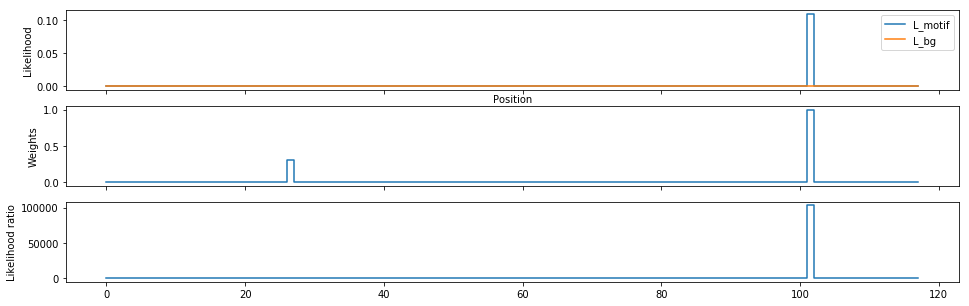

In [349]:
fig, axes = plt.subplots(3, figsize=(16, 5), sharex=True)
i_seq = 1
start = i_seq*(window_size - motif_length)
end = start + (window_size - motif_length)
axes[0].step(np.arange(end - start), model.L_motif[start:end], label='L_motif')
axes[0].step(np.arange(end - start), model.L_bg[start:end], label='L_bg')
axes[0].set_ylabel('Likelihood')
axes[0].set_xlabel('Position')
axes[0].legend()

weights = model.L_motif[start:end]/(model.L_motif[start:end] + model.L_bg[start:end])
axes[1].step(np.arange(weights.shape[0]), weights)
axes[1].set_ylabel('Weights')

axes[2].step(np.arange(end - start),  model.L_motif[start:end]/model.L_bg[start:end])
axes[2].set_ylabel('Likelihood ratio')

In [333]:
ax.step?

In [169]:
model.pwm = transfac['PWM']
model.fit_step(X_windows)

-7001779.015006292

In [257]:
transfac['PO']

['A', 'C', 'G', 'T']

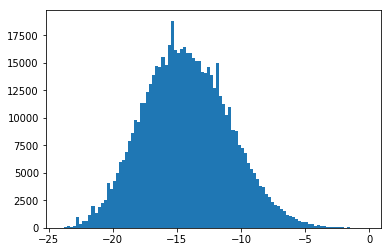

In [175]:
h = hist(np.log10(model.L_motif), bins=100)

In [163]:
transfac['PWM']

array([[6.81281418e-01, 4.09143639e-02, 1.92748148e-01, 8.50560695e-02],
       [2.49887161e-02, 9.39805507e-01, 3.03434410e-02, 4.86233638e-03],
       [7.78378378e-03, 9.90443243e-01, 1.29729730e-03, 4.75675676e-04],
       [2.18064460e-05, 4.79741812e-04, 9.98909678e-01, 5.88774042e-04],
       [1.07367562e-04, 9.01887522e-04, 9.83658657e-01, 1.53320879e-02],
       [9.92998201e-01, 5.07251089e-03, 1.36567601e-03, 5.63612321e-04],
       [9.47052864e-01, 6.90524923e-03, 1.26113833e-03, 4.47807480e-02],
       [5.86030069e-02, 4.58801134e-02, 8.89786722e-01, 5.73015811e-03],
       [1.69316272e-02, 1.16508798e-01, 2.07537067e-02, 8.45805868e-01],
       [2.89777564e-01, 1.45685534e-01, 3.77071009e-01, 1.87465892e-01]])

In [340]:
model.mix

0.10436834268986181

In [91]:
model.L_motif/(model.L_motif + model.L_bg)

array([0.01651898, 0.74075674, 0.07410645, ..., 0.10821304, 0.27615688,
       0.36249171])

In [341]:
model.pwm

array([[0.35321489, 0.32715734, 0.1150932 , 0.20453457],
       [0.23884983, 0.24294987, 0.28191221, 0.23628809],
       [0.2487904 , 0.27422531, 0.22407602, 0.25290827],
       [0.21676488, 0.25165763, 0.24377231, 0.28780517],
       [0.24707338, 0.25433779, 0.25140473, 0.24718411],
       [0.33906569, 0.30242939, 0.338362  , 0.02014291],
       [0.25882796, 0.22553695, 0.31332721, 0.20230787],
       [0.06734275, 0.30001134, 0.34153368, 0.29111223],
       [0.19362705, 0.27281611, 0.25033683, 0.28322001],
       [0.27874363, 0.20206052, 0.24947417, 0.26972167]])

In [270]:
model.bgprob

array([0.25562927, 0.23869206, 0.25133654, 0.25434213])

In [119]:
np.random.dirichlet([0.5]*4)

array([0.01120497, 0.18755265, 0.67764158, 0.1236008 ])

In [126]:
from scipy.stats import dirichlet

In [125]:
diric?

In [150]:
-dirichlet.entropy([0.3]*4)

4.529190042426626

In [149]:
np.random.dirichlet([0.3]*4, size=10)

array([[9.17720879e-01, 8.01846068e-02, 2.09274749e-03, 1.76670221e-06],
       [2.34724362e-01, 6.55082803e-07, 6.89219857e-01, 7.60551264e-02],
       [7.53189094e-01, 1.45809585e-01, 9.66887117e-03, 9.13324502e-02],
       [8.77661426e-01, 6.86010448e-02, 5.33890396e-02, 3.48489996e-04],
       [3.00745086e-02, 5.00551195e-02, 3.93981939e-02, 8.80472178e-01],
       [5.22197555e-04, 3.31457947e-03, 2.75540968e-02, 9.68609126e-01],
       [8.88456573e-01, 5.50813411e-05, 1.06541451e-03, 1.10422931e-01],
       [5.19159737e-02, 5.36522419e-01, 6.47356409e-02, 3.46825966e-01],
       [2.45640586e-01, 1.54573264e-01, 1.19843820e-02, 5.87801768e-01],
       [6.35186369e-02, 2.96767068e-03, 2.09146242e-01, 7.24367450e-01]])